In [1]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
# confusion matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /Users/macos/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [3]:
# Set Parameters
IMG_SIZE = 48  # Width and height
BATCH_SIZE = 64
SEED = 42
DATA_DIR = path

# Emotion categories will be inferred automatically from folder names

In [4]:
# Load training dataset with validation split (before normalization)
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',  # integer labels
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='training'
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

# 4️⃣ Load test dataset (no validation split)
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [5]:
# Get class names before mapping (IMPORTANT)
class_names = raw_train_ds.class_names
class_indices = dict(zip(class_names, range(len(class_names))))
print("Emotion Label Mapping:", class_indices)

Emotion Label Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use this only during model training
cnn_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [16]:
def get_cnn_model():
    # CNN Architecture
    cnn_model = models.Sequential([
        layers.Input(shape=(48, 48, 1)),  # Grayscale image input

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),


        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(7, activation='softmax')  # 7 emotion classes
    ])

    # Compile the Model
    cnn_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return cnn_model

In [8]:
# Normalize datasets using Rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = raw_test_ds.map(lambda x, y: (normalization_layer(x), y))

# Convert to NumPy arrays (for use with traditional ML models)
def convert_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train_np, y_train_np = convert_to_numpy(train_ds)
X_val_np, y_val_np = convert_to_numpy(val_ds)
X_test_np, y_test_np = convert_to_numpy(test_ds)

print("Train shape:", X_train_np.shape)
print("Validation shape:", X_val_np.shape)
print("Test shape:", X_test_np.shape)

# One-hot encode labels for deep learning models
y_train_oh = to_categorical(y_train_np, num_classes=7)
y_val_oh = to_categorical(y_val_np, num_classes=7)
y_test_oh = to_categorical(y_test_np, num_classes=7)

Train shape: (22968, 48, 48, 1)
Validation shape: (5741, 48, 48, 1)
Test shape: (7178, 48, 48, 1)


In [9]:
# Plot Training and Validation Curves
def plot_history(history, title="Model"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/40


/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2387 - loss: 2.0155
Epoch 1: val_accuracy improved from -inf to 0.35569, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.2388 - loss: 2.0150 - val_accuracy: 0.3557 - val_loss: 1.6339
Epoch 2/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.2188 - loss: 1.7962

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.35569
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2188 - loss: 1.7962 - val_accuracy: 0.3442 - val_loss: 1.6425
Epoch 3/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3375 - loss: 1.6583
Epoch 3: val_accuracy improved from 0.35569 to 0.39558, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.3375 - loss: 1.6582 - val_accuracy: 0.3956 - val_loss: 1.5613
Epoch 4/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.5000 - loss: 1.3740
Epoch 4: val_accuracy did not improve from 0.39558
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5000 - loss: 1.3740 - val_accuracy: 0.3951 - val_loss: 1.5707
Epoch 5/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3962 - loss: 1.5482
Epoch 5: val_accuracy improved from 0.39558 to 0.43303, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.3962 - loss: 1.5481 - val_accuracy: 0.4330 - val_loss: 1.4443
Epoch 6/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 1:00 85ms/step - accuracy: 0.2812 - loss: 1.6182
Epoch 6: val_accuracy did not improve from 0.43303
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2812 - loss: 1.6182 - val_accuracy: 0.4186 - val_loss: 1.4694
Epoch 7/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4187 - loss: 1.4863
Epoch 7: val_accuracy improved from 0.43303 to 0.43790, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.4187 - loss: 1.4862 - val_accuracy: 0.4379 - val_loss: 1.4706
Epoch 8/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.5000 - loss: 1.2805
Epoch 8: val_accuracy improved from 0.43790 to 0.43982, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5000 - loss: 1.2805 - val_accuracy: 0.4398 - val_loss: 1.4631
Epoch 9/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4461 - loss: 1.4322
Epoch 9: val_accuracy improved from 0.43982 to 0.50462, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.4461 - loss: 1.4321 - val_accuracy: 0.5046 - val_loss: 1.3229
Epoch 10/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.4281
Epoch 10: val_accuracy improved from 0.50462 to 0.50636, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.4281 - val_accuracy: 0.5064 - val_loss: 1.3219
Epoch 11/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4597 - loss: 1.4044
Epoch 11: val_accuracy did not improve from 0.50636
717/717 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.4597 - loss: 1.4043 - val_accuracy: 0.4933 - val_loss: 1.3381
Epoch 12/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step - accuracy: 0.6562 - loss: 1.1680
Epoch 12: val_accuracy did not improve from 0.50636
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6562 - loss: 1.1680 - val_accuracy: 0.4886 - val_loss: 1.3440
Epoch 13/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4739 - loss: 1.3735
Epoch 13: val_accuracy did not improve from 0.50636
717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.4739 - loss: 1.3735 - val_accuracy: 0.4745 - val_loss: 1.3647
Epoch 14/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.5000 - loss: 1.2724
Epoch 14: val_accu

717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.4839 - loss: 1.3494 - val_accuracy: 0.5422 - val_loss: 1.2187
Epoch 16/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.5938 - loss: 1.2604
Epoch 16: val_accuracy improved from 0.54224 to 0.54294, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5938 - loss: 1.2604 - val_accuracy: 0.5429 - val_loss: 1.2171
Epoch 17/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4924 - loss: 1.3285
Epoch 17: val_accuracy did not improve from 0.54294
717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.4924 - loss: 1.3285 - val_accuracy: 0.5309 - val_loss: 1.2397
Epoch 18/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.7188 - loss: 1.0841
Epoch 18: val_accuracy did not improve from 0.54294
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 1.0841 - val_accuracy: 0.5321 - val_loss: 1.2348
Epoch 19/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5042 - loss: 1.3042
Epoch 19: val_accuracy did not improve from 0.54294
717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.5042 - loss: 1.3042 - val_accuracy: 0.5257 - val_loss: 1.2395
Epoch 20/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.3750 - loss: 1.3695
Epoch 20: val_accu

717/717 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.5106 - loss: 1.2916 - val_accuracy: 0.5539 - val_loss: 1.1806
Epoch 22/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.4688 - loss: 1.3726
Epoch 22: val_accuracy improved from 0.55391 to 0.55600, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.3726 - val_accuracy: 0.5560 - val_loss: 1.1764
Epoch 23/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5123 - loss: 1.2789
Epoch 23: val_accuracy did not improve from 0.55600
717/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.5123 - loss: 1.2790 - val_accuracy: 0.5266 - val_loss: 1.2474
Epoch 24/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.5625 - loss: 1.3078
Epoch 24: val_accuracy did not improve from 0.55600
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5625 - loss: 1.3078 - val_accuracy: 0.5194 - val_loss: 1.2705
Epoch 25/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5132 - loss: 1.2826
Epoch 25: val_accuracy did not improve from 0.55600
717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.5132 - loss: 1.2826 - val_accuracy: 0.5557 - val_loss: 1.1888
Epoch 26/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.4688 - loss: 1.4093
Epoch 26: val_accu

717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.4093 - val_accuracy: 0.5562 - val_loss: 1.1907
Epoch 27/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5183 - loss: 1.2676
Epoch 27: val_accuracy did not improve from 0.55617
717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.5183 - loss: 1.2676 - val_accuracy: 0.5414 - val_loss: 1.2162
Epoch 28/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - accuracy: 0.5625 - loss: 1.3646
Epoch 28: val_accuracy did not improve from 0.55617
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5625 - loss: 1.3646 - val_accuracy: 0.5348 - val_loss: 1.2254
Epoch 29/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5294 - loss: 1.2344
Epoch 29: val_accuracy improved from 0.55617 to 0.56558, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.5293 - loss: 1.2344 - val_accuracy: 0.5656 - val_loss: 1.1469
Epoch 30/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.4375 - loss: 1.3863
Epoch 30: val_accuracy improved from 0.56558 to 0.56610, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4375 - loss: 1.3863 - val_accuracy: 0.5661 - val_loss: 1.1447
Epoch 31/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5379 - loss: 1.2217
Epoch 31: val_accuracy did not improve from 0.56610
717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.5379 - loss: 1.2217 - val_accuracy: 0.5602 - val_loss: 1.1736
Epoch 32/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.5312 - loss: 1.1214
Epoch 32: val_accuracy did not improve from 0.56610
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: 1.1214 - val_accuracy: 0.5602 - val_loss: 1.1629
Epoch 33/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5361 - loss: 1.2285
Epoch 33: val_accuracy improved from 0.56610 to 0.56906, saving model to best_emotion_model02_01_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.5361 - loss: 1.2285 - val_accuracy: 0.5691 - val_loss: 1.1405
Epoch 34/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.4688 - loss: 1.4404
Epoch 34: val_accuracy did not improve from 0.56906
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.4404 - val_accuracy: 0.5675 - val_loss: 1.1451
Epoch 35/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5364 - loss: 1.2136
Epoch 35: val_accuracy did not improve from 0.56906
717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.5364 - loss: 1.2136 - val_accuracy: 0.5374 - val_loss: 1.2273
Epoch 36/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.5312 - loss: 1.2055
Epoch 36: val_accuracy did not improve from 0.56906
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: 1.2055 - val_accuracy: 0.5269 - val_loss: 1.2537
Epoch 37/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5374 - loss: 1.2095
Epoch 37: val_accu

717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.5419 - loss: 1.2055 - val_accuracy: 0.5802 - val_loss: 1.0938
Epoch 40/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 1:00 85ms/step - accuracy: 0.6562 - loss: 1.0759
Epoch 40: val_accuracy did not improve from 0.58021
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6562 - loss: 1.0759 - val_accuracy: 0.5767 - val_loss: 1.1007


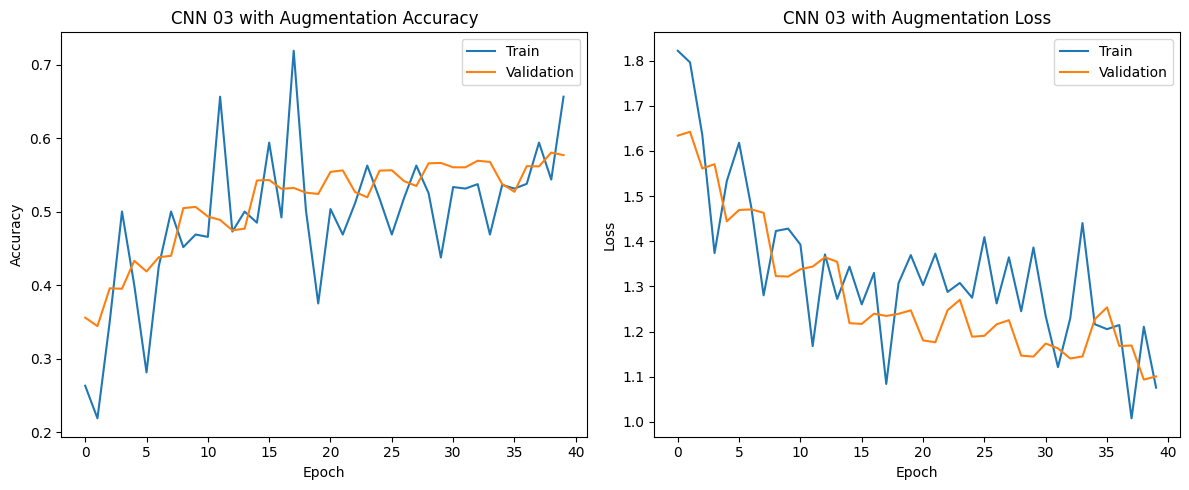

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Test Accuracy: 0.5821955976595152


In [11]:
# Use in model training

checkpoint = ModelCheckpoint(
    'best_emotion_model02_01_checkpoint.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_cnn01 = cnn_model.fit(
    cnn_augmentation.flow(X_train_np, y_train_oh, batch_size=32),
    steps_per_epoch=len(X_train_np) // 32,
    epochs=40,
    validation_data=(X_val_np, y_val_oh),
    callbacks=[checkpoint]
)

cnn_model.save("fer2013_cnn_model2_01.h5")

plot_history(history_cnn01, title="CNN 03 with Augmentation")

y_pred_probs = cnn_model.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))

Epoch 1/40
  3/717 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.4740 - loss: 1.2936

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5454 - loss: 1.2027
Epoch 1: val_accuracy improved from -inf to 0.57568, saving model to best_emotion_model02_02_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5454 - loss: 1.2027 - val_accuracy: 0.5757 - val_loss: 1.1207
Epoch 2/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.6875 - loss: 1.0556

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.57568
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6875 - loss: 1.0556 - val_accuracy: 0.5743 - val_loss: 1.1229
Epoch 3/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5477 - loss: 1.1974
Epoch 3: val_accuracy improved from 0.57568 to 0.58387, saving model to best_emotion_model02_02_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.5477 - loss: 1.1973 - val_accuracy: 0.5839 - val_loss: 1.1155
Epoch 4/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.4375 - loss: 1.2495
Epoch 4: val_accuracy did not improve from 0.58387
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4375 - loss: 1.2495 - val_accuracy: 0.5811 - val_loss: 1.1176
Epoch 5/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5527 - loss: 1.1823
Epoch 5: val_accuracy improved from 0.58387 to 0.58788, saving model to best_emotion_model02_02_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.5527 - loss: 1.1823 - val_accuracy: 0.5879 - val_loss: 1.0996
Epoch 6/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.3438 - loss: 1.6082
Epoch 6: val_accuracy improved from 0.58788 to 0.58892, saving model to best_emotion_model02_02_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3438 - loss: 1.6082 - val_accuracy: 0.5889 - val_loss: 1.0965
Epoch 7/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5579 - loss: 1.1748
Epoch 7: val_accuracy did not improve from 0.58892
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.5579 - loss: 1.1748 - val_accuracy: 0.5710 - val_loss: 1.1221
Epoch 8/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.6562 - loss: 1.0589
Epoch 8: val_accuracy did not improve from 0.58892
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6562 - loss: 1.0589 - val_accuracy: 0.5745 - val_loss: 1.1162
Epoch 9/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5611 - loss: 1.1630
Epoch 9: val_accuracy did not improve from 0.58892
717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.5611 - loss: 1.1630 - val_accuracy: 0.5598 - val_loss: 1.1642
Epoch 10/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.6562 - loss: 0.8786
Epoch 10: val_accuracy d

717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.5646 - loss: 1.1457 - val_accuracy: 0.5975 - val_loss: 1.0688
Epoch 14/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5625 - loss: 1.1313
Epoch 14: val_accuracy improved from 0.59746 to 0.59763, saving model to best_emotion_model02_02_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5625 - loss: 1.1313 - val_accuracy: 0.5976 - val_loss: 1.0693
Epoch 15/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5672 - loss: 1.1496
Epoch 15: val_accuracy did not improve from 0.59763
717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.5672 - loss: 1.1496 - val_accuracy: 0.5884 - val_loss: 1.0785
Epoch 16/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.6562 - loss: 1.0570
Epoch 16: val_accuracy did not improve from 0.59763
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6562 - loss: 1.0570 - val_accuracy: 0.5903 - val_loss: 1.0756
Epoch 17/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5685 - loss: 1.1476
Epoch 17: val_accuracy did not improve from 0.59763
717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.5685 - loss: 1.1476 - val_accuracy: 0.5854 - val_loss: 1.0962
Epoch 18/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5000 - loss: 1.2567
Epoch 18: val_accu

717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.5803 - loss: 1.1241 - val_accuracy: 0.6074 - val_loss: 1.0515
Epoch 28/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.7188 - loss: 0.8512
Epoch 28: val_accuracy did not improve from 0.60739
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 0.8512 - val_accuracy: 0.6044 - val_loss: 1.0546
Epoch 29/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5714 - loss: 1.1247
Epoch 29: val_accuracy did not improve from 0.60739
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.5715 - loss: 1.1247 - val_accuracy: 0.5975 - val_loss: 1.0724
Epoch 30/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.7500 - loss: 0.7753
Epoch 30: val_accuracy did not improve from 0.60739
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7500 - loss: 0.7753 - val_accuracy: 0.5893 - val_loss: 1.0886
Epoch 31/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5856 - loss: 1.1000
Epoch 31: val_accu

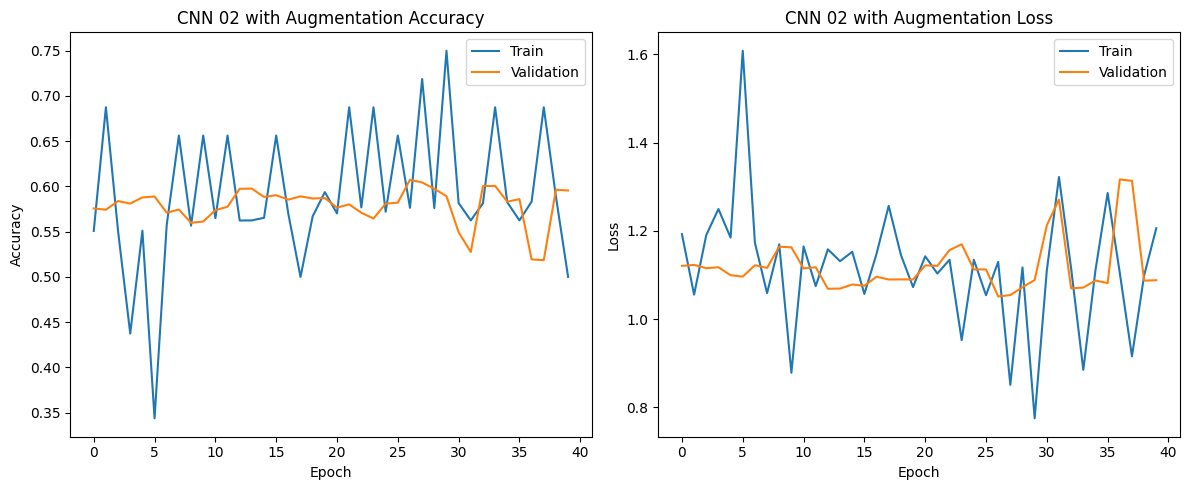

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Test Accuracy: 0.5984954026191139


In [12]:
# Use in model training
# continue training
checkpoint = ModelCheckpoint(
    'best_emotion_model02_02_checkpoint.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_cnn01 = cnn_model.fit(
    cnn_augmentation.flow(X_train_np, y_train_oh, batch_size=32),
    steps_per_epoch=len(X_train_np) // 32,
    epochs=40,
    validation_data=(X_val_np, y_val_oh),
    callbacks=[checkpoint]
)

cnn_model.save("fer2013_cnn_model2_02.h5")

plot_history(history_cnn01, title="CNN 02 with Augmentation")

y_pred_probs = cnn_model.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))

In [15]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def compute_class_weights(dataset, class_names):
    """
    Compute class weights for imbalanced dataset
    Args:
        dataset: tf.data.Dataset with integer labels
        class_names: list of class names
    Returns:
        dict: class weights dictionary
    """
    labels = []

    # Extract labels from dataset
    for _, batch_labels in dataset:
        # Since label_mode='int', labels are already integers
        labels.extend(batch_labels.numpy())

    labels = np.array(labels)

    # Compute class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(labels),
        y=labels
    )

    # Create dictionary mapping class index to weight
    class_weight_dict = dict(enumerate(class_weights))

    # Print class distribution for debugging
    unique, counts = np.unique(labels, return_counts=True)
    print("Class distribution:")
    for i, (class_idx, count) in enumerate(zip(unique, counts)):
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class_{class_idx}"
        print(f"  {class_name}: {count} samples (weight: {class_weight_dict[class_idx]:.3f})")

    return class_weight_dict

# Compute class weights
class_weights = compute_class_weights(raw_train_ds, class_names)
print(f"\nFinal class weights: {class_weights}")

Class distribution:
  angry: 3218 samples (weight: 1.020)
  disgust: 363 samples (weight: 9.039)
  fear: 3285 samples (weight: 0.999)
  happy: 5813 samples (weight: 0.564)
  neutral: 3965 samples (weight: 0.828)
  sad: 3834 samples (weight: 0.856)
  surprise: 2490 samples (weight: 1.318)

Final class weights: {0: 1.0196217703986505, 1: 9.03896103896104, 2: 0.998825831702544, 3: 0.5644491410877098, 4: 0.8275265717888669, 5: 0.8558014755197854, 6: 1.3177280550774526}


Epoch 1/40


/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1698 - loss: 2.2877
Epoch 1: val_accuracy improved from -inf to 0.20885, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.1699 - loss: 2.2870 - val_accuracy: 0.2088 - val_loss: 1.9007
Epoch 2/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.3125 - loss: 1.4500

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.20885 to 0.20955, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3125 - loss: 1.4500 - val_accuracy: 0.2095 - val_loss: 1.8876
Epoch 3/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1873 - loss: 1.8769
Epoch 3: val_accuracy did not improve from 0.20955
717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.1872 - loss: 1.8769 - val_accuracy: 0.1540 - val_loss: 2.0144
Epoch 4/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.2188 - loss: 1.5748
Epoch 4: val_accuracy did not improve from 0.20955
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2188 - loss: 1.5748 - val_accuracy: 0.1569 - val_loss: 2.0172
Epoch 5/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1638 - loss: 1.8662
Epoch 5: val_accuracy did not improve from 0.20955
717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.1638 - loss: 1.8662 - val_accuracy: 0.1939 - val_loss: 1.8511
Epoch 6/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.2812 - loss: 2.1135
Epoch 6: val_accuracy did

717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.2219 - loss: 1.8204 - val_accuracy: 0.3045 - val_loss: 1.8501
Epoch 8/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.2188 - loss: 2.0250
Epoch 8: val_accuracy improved from 0.30448 to 0.30517, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2188 - loss: 2.0250 - val_accuracy: 0.3052 - val_loss: 1.8479
Epoch 9/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2561 - loss: 1.7707
Epoch 9: val_accuracy did not improve from 0.30517
717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.2561 - loss: 1.7707 - val_accuracy: 0.2719 - val_loss: 1.7560
Epoch 10/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.1562 - loss: 1.9979
Epoch 10: val_accuracy did not improve from 0.30517
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1562 - loss: 1.9979 - val_accuracy: 0.2712 - val_loss: 1.7529
Epoch 11/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2663 - loss: 1.7752
Epoch 11: val_accuracy did not improve from 0.30517
717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.2664 - loss: 1.7752 - val_accuracy: 0.2970 - val_loss: 1.7553
Epoch 12/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.2188 - loss: 1.7936
Epoch 12: val_accura

717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.3248 - loss: 1.6855 - val_accuracy: 0.4109 - val_loss: 1.5504
Epoch 16/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.3438 - loss: 1.3186
Epoch 16: val_accuracy did not improve from 0.41090
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3438 - loss: 1.3186 - val_accuracy: 0.4090 - val_loss: 1.5503
Epoch 17/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3605 - loss: 1.6482
Epoch 17: val_accuracy did not improve from 0.41090
717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.3605 - loss: 1.6482 - val_accuracy: 0.3583 - val_loss: 1.6503
Epoch 18/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.4062 - loss: 2.2333
Epoch 18: val_accuracy did not improve from 0.41090
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4062 - loss: 2.2333 - val_accuracy: 0.3573 - val_loss: 1.6470
Epoch 19/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3569 - loss: 1.6311
Epoch 19: val_accu

717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.3880 - loss: 1.5617 - val_accuracy: 0.4288 - val_loss: 1.4798
Epoch 24/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.3125 - loss: 1.6178
Epoch 24: val_accuracy improved from 0.42885 to 0.43372, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3125 - loss: 1.6178 - val_accuracy: 0.4337 - val_loss: 1.4766
Epoch 25/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3919 - loss: 1.5553
Epoch 25: val_accuracy improved from 0.43372 to 0.45846, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.3919 - loss: 1.5553 - val_accuracy: 0.4585 - val_loss: 1.4195
Epoch 26/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.3438 - loss: 1.4296
Epoch 26: val_accuracy did not improve from 0.45846
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3438 - loss: 1.4296 - val_accuracy: 0.4565 - val_loss: 1.4252
Epoch 27/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3993 - loss: 1.5051
Epoch 27: val_accuracy improved from 0.45846 to 0.47291, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.3993 - loss: 1.5052 - val_accuracy: 0.4729 - val_loss: 1.3746
Epoch 28/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.4375 - loss: 1.2828
Epoch 28: val_accuracy did not improve from 0.47291
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4375 - loss: 1.2828 - val_accuracy: 0.4722 - val_loss: 1.3774
Epoch 29/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4135 - loss: 1.5036
Epoch 29: val_accuracy did not improve from 0.47291
717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.4135 - loss: 1.5036 - val_accuracy: 0.4426 - val_loss: 1.4501
Epoch 30/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.3333 - loss: 2.3470
Epoch 30: val_accuracy did not improve from 0.47291
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3333 - loss: 2.3470 - val_accuracy: 0.4396 - val_loss: 1.4654
Epoch 31/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4094 - loss: 1.5067
Epoch 31: val_accu

717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.4095 - loss: 1.5066 - val_accuracy: 0.4844 - val_loss: 1.3366
Epoch 32/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.4688 - loss: 1.2115
Epoch 32: val_accuracy did not improve from 0.48441
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.2115 - val_accuracy: 0.4827 - val_loss: 1.3344
Epoch 33/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4204 - loss: 1.5042
Epoch 33: val_accuracy did not improve from 0.48441
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.4204 - loss: 1.5041 - val_accuracy: 0.4801 - val_loss: 1.3758
Epoch 34/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.3750 - loss: 2.5202
Epoch 34: val_accuracy did not improve from 0.48441
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3750 - loss: 2.5202 - val_accuracy: 0.4808 - val_loss: 1.3585
Epoch 35/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4224 - loss: 1.4872
Epoch 35: val_accu

717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.4296 - loss: 1.4367 - val_accuracy: 0.4856 - val_loss: 1.2982
Epoch 40/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.5938 - loss: 1.1124
Epoch 40: val_accuracy did not improve from 0.48563
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5938 - loss: 1.1124 - val_accuracy: 0.4855 - val_loss: 1.3007


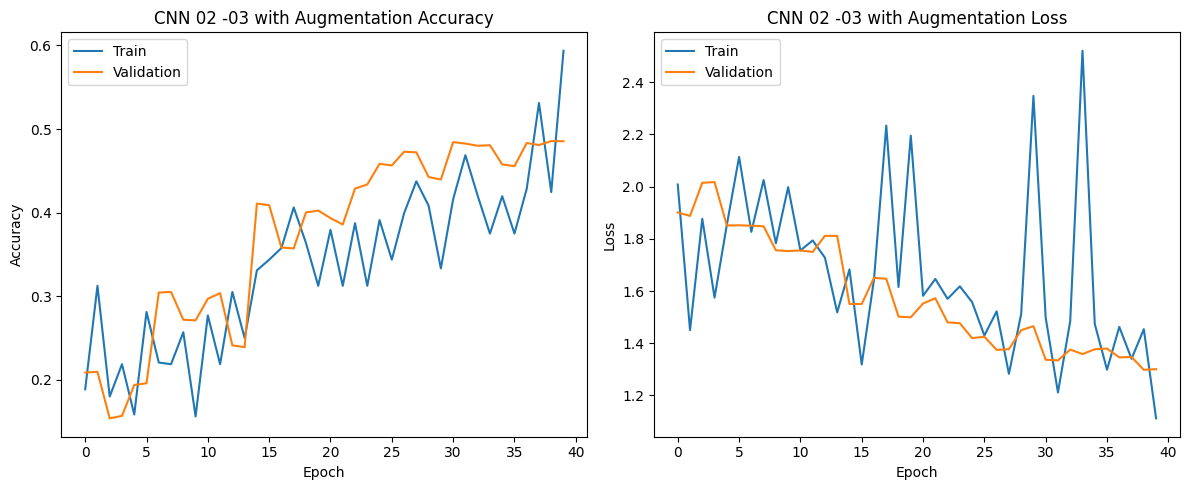

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Test Accuracy: 0.5117024240735581


In [17]:
cnn_model_weights = get_cnn_model()

# Use in model training
# continue training
checkpoint = ModelCheckpoint(
    'best_emotion_model02_03_checkpoint.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_cnn01 = cnn_model_weights.fit(
    cnn_augmentation.flow(X_train_np, y_train_oh, batch_size=32),
    class_weight=class_weights,
    steps_per_epoch=len(X_train_np) // 32,
    epochs=40,
    validation_data=(X_val_np, y_val_oh),
    callbacks=[checkpoint]
)

cnn_model_weights.save("fer2013_cnn_model2_03_03.h5")

plot_history(history_cnn01, title="CNN 02 -03 with Augmentation")

y_pred_probs = cnn_model_weights.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))

Epoch 1/40
  3/717 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.3854 - loss: 1.3801

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4388 - loss: 1.4079
Epoch 1: val_accuracy improved from -inf to 0.38547, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.4387 - loss: 1.4079 - val_accuracy: 0.3855 - val_loss: 1.5736
Epoch 2/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.3438 - loss: 1.7040

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.38547
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3438 - loss: 1.7040 - val_accuracy: 0.3789 - val_loss: 1.5918
Epoch 3/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4302 - loss: 1.4346
Epoch 3: val_accuracy improved from 0.38547 to 0.46926, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.4302 - loss: 1.4346 - val_accuracy: 0.4693 - val_loss: 1.3820
Epoch 4/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.1345
Epoch 4: val_accuracy did not improve from 0.46926
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.1345 - val_accuracy: 0.4686 - val_loss: 1.3791
Epoch 5/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4475 - loss: 1.4040
Epoch 5: val_accuracy improved from 0.46926 to 0.51663, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.4475 - loss: 1.4040 - val_accuracy: 0.5166 - val_loss: 1.2770
Epoch 6/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.4375 - loss: 1.2705
Epoch 6: val_accuracy improved from 0.51663 to 0.51803, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4375 - loss: 1.2705 - val_accuracy: 0.5180 - val_loss: 1.2780
Epoch 7/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4531 - loss: 1.3956
Epoch 7: val_accuracy did not improve from 0.51803
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.4531 - loss: 1.3956 - val_accuracy: 0.4968 - val_loss: 1.3144
Epoch 8/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.5312 - loss: 1.2757
Epoch 8: val_accuracy did not improve from 0.51803
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: 1.2757 - val_accuracy: 0.4947 - val_loss: 1.3110
Epoch 9/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4624 - loss: 1.3723
Epoch 9: val_accuracy did not improve from 0.51803
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.4624 - loss: 1.3723 - val_accuracy: 0.4875 - val_loss: 1.3315
Epoch 10/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.6250 - loss: 1.1485
Epoch 10: val_accuracy d

717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.4725 - loss: 1.3267 - val_accuracy: 0.5231 - val_loss: 1.2303
Epoch 22/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.5000 - loss: 1.3717
Epoch 22: val_accuracy improved from 0.52308 to 0.52430, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5000 - loss: 1.3717 - val_accuracy: 0.5243 - val_loss: 1.2286
Epoch 23/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4758 - loss: 1.3227
Epoch 23: val_accuracy did not improve from 0.52430
717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.4758 - loss: 1.3227 - val_accuracy: 0.4781 - val_loss: 1.3656
Epoch 24/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.5312 - loss: 1.1855
Epoch 24: val_accuracy did not improve from 0.52430
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: 1.1855 - val_accuracy: 0.4769 - val_loss: 1.3697
Epoch 25/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4659 - loss: 1.3634
Epoch 25: val_accuracy improved from 0.52430 to 0.54294, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.4659 - loss: 1.3633 - val_accuracy: 0.5429 - val_loss: 1.2239
Epoch 26/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.5938 - loss: 1.1210
Epoch 26: val_accuracy did not improve from 0.54294
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5938 - loss: 1.1210 - val_accuracy: 0.5401 - val_loss: 1.2258
Epoch 27/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4800 - loss: 1.3404
Epoch 27: val_accuracy improved from 0.54294 to 0.54468, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.4800 - loss: 1.3404 - val_accuracy: 0.5447 - val_loss: 1.1908
Epoch 28/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.5312 - loss: 1.2767
Epoch 28: val_accuracy improved from 0.54468 to 0.54625, saving model to best_emotion_model02_03_checkpoint.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: 1.2767 - val_accuracy: 0.5462 - val_loss: 1.1896
Epoch 29/40
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4785 - loss: 1.3329
Epoch 29: val_accuracy did not improve from 0.54625
717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.4785 - loss: 1.3329 - val_accuracy: 0.5302 - val_loss: 1.2350
Epoch 30/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.4688 - loss: 1.1924
Epoch 30: val_accuracy did not improve from 0.54625
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.1924 - val_accuracy: 0.5278 - val_loss: 1.2386
Epoch 31/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4833 - loss: 1.2972
Epoch 31: val_accuracy did not improve from 0.54625
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.4833 - loss: 1.2972 - val_accuracy: 0.5395 - val_loss: 1.1999
Epoch 32/40
  1/717 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.4375 - loss: 1.5698
Epoch 32: val_accu

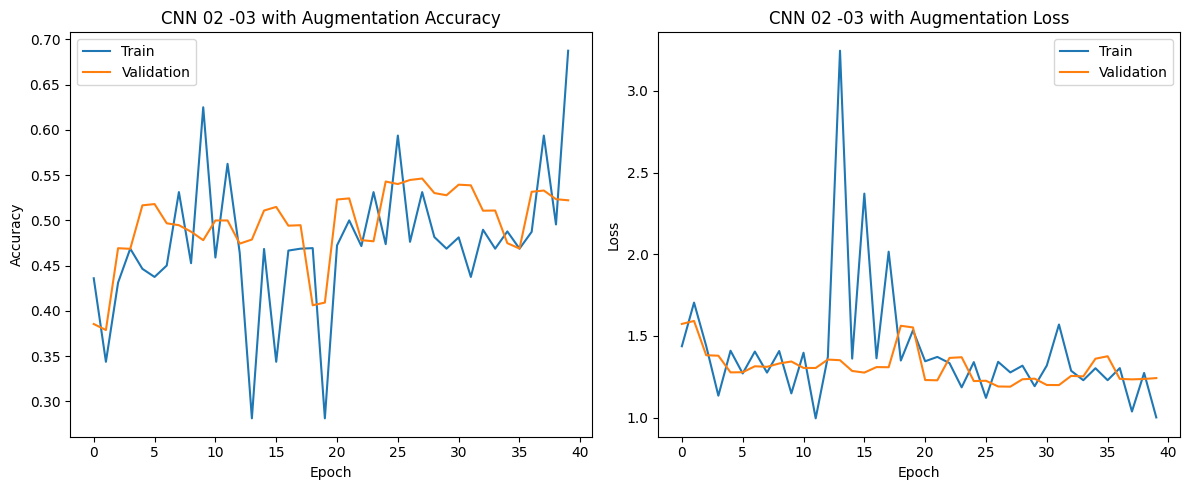

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Test Accuracy: 0.5319030370576763


In [18]:
# continue training
checkpoint = ModelCheckpoint(
    'best_emotion_model02_03_checkpoint.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_cnn01 = cnn_model_weights.fit(
    cnn_augmentation.flow(X_train_np, y_train_oh, batch_size=32),
    class_weight=class_weights,
    steps_per_epoch=len(X_train_np) // 32,
    epochs=40,
    validation_data=(X_val_np, y_val_oh),
    callbacks=[checkpoint]
)

cnn_model_weights.save("fer2013_cnn_model2_03_03.h5")

plot_history(history_cnn01, title="CNN 02 -03 with Augmentation")

y_pred_probs = cnn_model_weights.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))